In [1]:
import os.path
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.preprocessing import normalize

from soma.tests.som import som_test

plt.style.use('seaborn')
plt.style.use('seaborn-paper')

Dataset from https://analyse.kmi.open.ac.uk/open_dataset

The SOM test can tell me if P=Q or not.

In this case, $P=Q$ imply that the samples come from the same population.

Let's start by defining (arguably) sensitive attributes:

1. `disability`
2. `imd_band` (i.e. poverty)

Can we infer something about those given gender, education age and/or region? (Well, without looking I can guess)
What would the $H_0$ be? Well, region is almost surely going to leak `imd_band`. But maybe we can get a hint
at the specific student ids and cross them with some of the other tables?

Let's start with that idea and we can iterate later.

In [2]:
# Load dataset
sinfo = pandas.read_csv('../soma/generators/data/oula/studentInfo.csv')
sinfo.dropna(inplace=True)

In [3]:
age = np.asarray(['0-35', '35-55', '55<='])
education = np.asarray(['No Formal quals', 'Lower Than A Level', 'A Level or Equivalent', 'HE Qualification', 'Post Graduate Qualification'])
imd = np.asarray(['0-10%', '10-20', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'])

In [4]:
# Make the attributes numeric so this thing works
gender, gender_int = np.unique(sinfo['gender'], return_inverse=True)
region, region_int = np.unique(sinfo['region'], return_inverse=True)
education_int = sinfo['highest_education'].replace(education, np.arange(len(education)))
age_int = sinfo['age_band'].replace(age, np.arange(len(age)))
imd_int = sinfo['imd_band'].replace(imd, np.arange(len(imd)))
dis, dis_int = np.unique(sinfo['disability'], return_inverse=True)

features_int = np.stack([gender_int, region_int, age_int, education_int], axis=-1)
features_int.shape

(31482, 4)

In [5]:
features = normalize(features_int, axis=0)

In [6]:
len(gender) * len(region) * len(age) * len(education)

390

In [7]:
# Let's ask for high poverty
low_imd_mask = (imd_int == 0)
low_imd_feat = features[low_imd_mask]
low_imd_feat_int = features_int[low_imd_mask]

## Cross-check, two random samples of the whole population should fail to reject $H_0$

In [8]:
p, som, (counts_all, counts_sample) = som_test(features[np.random.choice(len(features), len(low_imd_feat))],
                                               features[np.random.choice(len(features), len(low_imd_feat))],
                                               size=(20, 20), ret_som=True, ret_counts=True)
p

0.041209302124810554

$H_0$ can not be rejected.

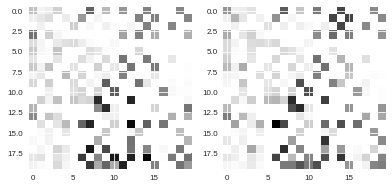

In [9]:
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(counts_all)
axes[1].imshow(counts_sample)
plt.show()

## Hypothesis test

In [10]:
general_sample = features[np.random.choice(len(features), len(low_imd_feat))]
low_imd_feat_sample = low_imd_feat

p, som, (counts_all, counts_low_imd) = som_test(general_sample, low_imd_feat_sample, size=(10, 10), ret_som=True,
                                                ret_counts=True)
p

0.0

$H_0$ can be rejected with a high significance level. We can accept instead the alternative hypothesis: the distribution of the QI for low income differ

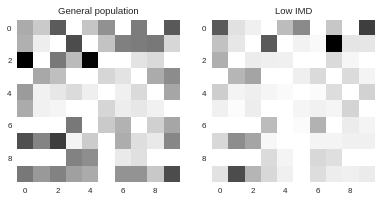

In [11]:
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(counts_all)
axes[0].set_title('General population')
axes[1].imshow(counts_low_imd)
axes[1].set_title('Low IMD')
axes[0].grid(False)
axes[1].grid(False)
plt.savefig(os.path.expanduser('~/Plots/imd.eps'), bbox_inches='tight')
plt.show()

They do look different.

/tmp/ipykernel_47304/2034441955.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad('white',1.)


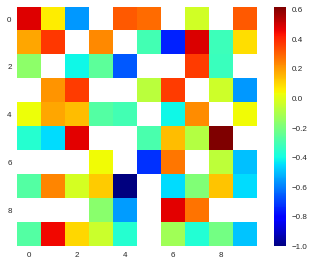

In [12]:
import matplotlib

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    chi2 = (counts_low_imd - counts_all) / (counts_low_imd + counts_all)
cmap = matplotlib.cm.jet
cmap.set_bad('white',1.)
plt.imshow(chi2, cmap=cmap)
plt.colorbar()
plt.grid(False)
plt.savefig(os.path.expanduser('~/Plots/imd_chi2.eps'), bbox_inches='tight')
plt.show()

The more extremes are the most interesting.
* 1 would mean all are (very) poor
* -1 would mean there aren't any (very) poor.

### Can we guess who is likely to be poor?

In [13]:
np.nanmax(chi2), np.nanmin(chi2)

(0.6176470588235294, -1.0)

In [14]:
#[gender_int, region_int, education_int, age_int]
idxs = np.argwhere((som.bmus == np.flip(np.unravel_index(np.nanargmax(chi2), chi2.shape))).all(axis=1)).ravel()
idxs = idxs[idxs > len(general_sample)] - len(general_sample)
uni, counts = np.unique(low_imd_feat_int[idxs], axis=0, return_counts=True)
np.column_stack([uni, counts])[np.flip(np.argsort(counts))]

array([[ 0,  5,  1,  1, 43],
       [ 0,  4,  1,  1,  7],
       [ 0,  5,  1,  0,  5]])

In [32]:
gender[0], region[5], age[1], education[0]

('F', 'North Western Region', '35-55', 'No Formal quals')

In [33]:
mask = (features_int == ([0, 5, 1, 0])).all(axis=1)
mask.sum()

5

/tmp/ipykernel_47304/2610307727.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(imd)


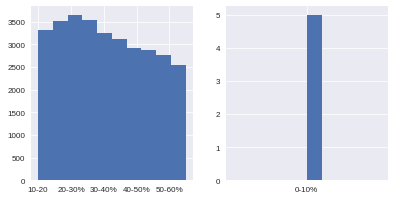

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][0]/2))
axes[0].hist(imd_int)
axes[0].set_xticklabels(imd)
axes[1].hist(imd[imd_int][mask])
plt.savefig(os.path.expanduser('~/Plots/imd_histogram.eps'), bbox_inches='tight')
plt.show()

We have identified 5 persons, female, North Western Region, middle aged and no education. All of them have low income.

# What about disability?

In [35]:
dis_feat = features[dis_int == 1]
dis_feat_int = features_int[dis_int == 1]
general_sample = features[np.random.choice(len(features), len(dis_feat))]

p, som, (counts_all_dis, counts_dis) = som_test(general_sample, dis_feat,
                                                size=(20, 20), ret_som=True,
                                                ret_counts=True)
p

0.0

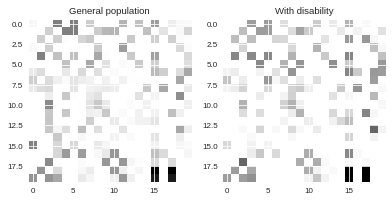

In [36]:
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(counts_all_dis)
axes[0].set_title('General population')
axes[1].imshow(counts_dis)
axes[1].set_title('With disability')
plt.show()

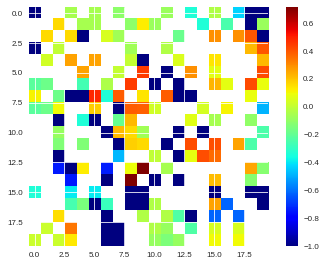

In [37]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    chi2_dis = (counts_dis - counts_all_dis) / (counts_dis + counts_all_dis)
plt.imshow(chi2_dis, cmap='jet')
plt.colorbar()
plt.show()

In [38]:
np.nanmax(chi2_dis), np.nanmin(chi2_dis)

(0.7142857142857143, -1.0)

In [39]:
#[gender_int, region_int, education_int, age_int]
idxs = np.argwhere((som.bmus == np.flip(np.unravel_index(np.nanargmax(chi2_dis), chi2_dis.shape))).all(axis=1)).ravel()
idxs = idxs[idxs > len(general_sample)] - len(general_sample)
uni, counts = np.unique(dis_feat_int[idxs], axis=0, return_counts=True)
np.column_stack([uni, counts])[np.flip(np.argsort(counts))]

array([[0, 5, 1, 3, 6]])

In [40]:
gender[0], region[5], age[1], education[3]

('F', 'North Western Region', '35-55', 'HE Qualification')

In [41]:
mask = (features_int == ([0, 5, 1, 3])).all(axis=1)
mask.sum()

42

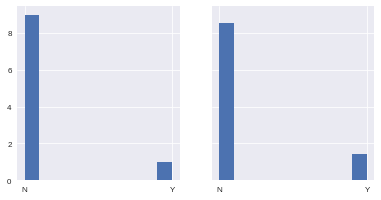

In [42]:
fig, axes = plt.subplots(ncols=2, figsize=(plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][0]/2), sharey=True)
axes[0].hist(dis[dis_int], density=True)
axes[1].hist(dis[dis_int[mask]], density=True)
plt.show()

Female, middle age, from Wales and lower than A education has a considerable higher likelihood of having a disability